In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

In [2]:
'''
grid sarchのパラメータ
{'colsample_bytree': 1.0,
 'learning_rate': 0.3,
 'max_depth': 10,
 'subsample': 1}

'''

"\ngrid sarchのパラメータ\n{'colsample_bytree': 1.0,\n 'learning_rate': 0.3,\n 'max_depth': 10,\n 'subsample': 1}\n\n"

In [3]:
cd ../

C:\Users\akite\OneDrive\デスクトップ\source code\twitter-compe


In [4]:
train_df = pd.read_csv('./data/preprosessing_train.csv')


In [5]:
X_df_train = train_df[["is_url","is_location","num_emoji","num_reply","num_hash","text_length","num_kusa","is_date","is_time","text_wakati"]]
Y_df_train = train_df["flg"].astype(np.int64)
X_train =  X_df_train.values
y_train = Y_df_train.values
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, random_state=1)

In [6]:
X_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20285 entries, 0 to 20284
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   is_url       20285 non-null  float64
 1   is_location  20285 non-null  float64
 2   num_emoji    20285 non-null  float64
 3   num_reply    20285 non-null  float64
 4   num_hash     20285 non-null  float64
 5   text_length  20285 non-null  float64
 6   num_kusa     20285 non-null  float64
 7   is_date      20285 non-null  float64
 8   is_time      20285 non-null  float64
 9   text_wakati  20285 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [7]:
#特徴量配列
X_train_feat = X_train[:,:8]
X_valid_feat = X_valid[:,:8]
X_train_feat.shape

(16228, 8)

In [8]:
#特徴量標準化
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
X_train_feat_ss = ss.fit_transform(X_train_feat)
X_valid_feat_ss = ss.transform(X_valid_feat)

In [9]:
#文字カラムに対する欠損値削除
X_train_del_one = X_train[:,9]
for idx in range(len(X_train_del_one)):
    if type(X_train_del_one[idx]) is float:
        X_train_del_one[idx] = " " 

X_valid_del_one = X_valid[:,9]
for idx in range(len(X_valid_del_one)):
    if type(X_valid_del_one[idx]) is float:
        X_valid_del_one[idx] = " " 

In [10]:
#単語ベクトル化(最大値、最小値を設定した)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = TfidfVectorizer(min_df=2/16228, max_df=16220/16228)
X_train_cv = cv.fit_transform(X_train_del_one)
X_valid_cv = cv.transform(X_valid_del_one)

In [11]:
#文字配列と特徴量の配列を結合する
X_train = np.concatenate([X_train_cv.toarray(),X_train_feat_ss],1)
X_valid = np.concatenate([X_valid_cv.toarray(),X_valid_feat_ss],1)

In [12]:
#型変換
X_train = X_train.astype(np.float64)
X_valid = X_valid.astype(np.float64)
y_train = y_train.astype(np.int64)
y_valid = y_valid.astype(np.int64)

In [13]:
#スパース配列に変換
from scipy.sparse import csr_matrix
X_train_csr = csr_matrix(X_train)
X_valid_csr = csr_matrix(X_valid)

In [14]:
from sklearn.model_selection import GridSearchCV
params = {"learning_rate":[0.25,0.3,0.35],
        "max_depth": [9,10,11,12],
         "subsample":[1,1.1,1.2],
         "colsample_bytree": [0.9,1.0,1.1],
         }

In [15]:

import xgboost as xgb
mod = xgb.XGBClassifier()
cv = GridSearchCV(mod, params, cv = 6, scoring= 'f1', n_jobs =2)
cv.fit(X_train_csr, y_train)

GridSearchCV(cv=6, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score, recall_score,f1_score
import seaborn as sns
def result_heatmap(Y_test,Y_pred):
    print("正解率:"+str(accuracy_score(Y_test, Y_pred)))
    print("適合率:"+str(recall_score(Y_test,Y_pred)))
    print("再現率:"+str(precision_score(Y_test,Y_pred)))
    print("F値:"+str(f1_score(Y_test, Y_pred)))  
    cm = confusion_matrix(Y_test, Y_pred)
    print(cm)
    sns.heatmap(cm,annot=True, cmap='Blues')

In [17]:

test_df = pd.read_csv('./data/preprosessing_test.csv')
X_df_test =  test_df[["is_url","is_location","num_emoji","num_reply","num_hash","text_length","num_kusa","is_date","is_time","text_wakati"]]
X_test = X_df_test.values
X_test_feat = X_test[:,:8]
X_test_feat_ss = ss.transform(X_test_feat)
X_test_del_one = X_test[:,9]
for idx in range(len(X_test_del_one)):
    if type(X_test_del_one[idx]) is float:
        X_test_del_one[idx] = " " 
X_test_cv = cv.transform(X_test_del_one)
print(X_test_cv.shape)
X_test = np.concatenate([X_test_cv.toarray(),X_test_feat_ss],1)
print(X_test.shape)
X_test = X_test.astype(np.float64)
X_test_csr = csr_matrix(X_test)
print(X_test_csr.shape)
y_pred_test = model.predict(X_test_csr)


AttributeError: 'XGBClassifier' object has no attribute 'transform'

In [18]:
cv.best_params_

{'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 9, 'subsample': 1}

正解率:0.9662312053241311
適合率:0.6183745583038869
再現率:0.8578431372549019
F値:0.7186858316221765
[[3745   29]
 [ 108  175]]


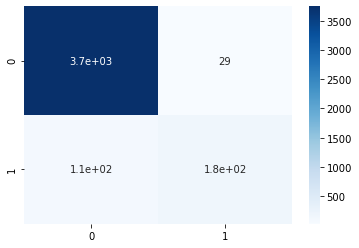

In [19]:

y_pred = cv.predict(X_valid_csr)
result_heatmap(y_valid,y_pred)
